In [93]:
from keras.models import load_model

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
poa = gpd.read_file("poa_selected.gpkg")
sa1 = gpd.read_file("sa1_to_poa.gpkg")
sa1 = sa1[["SA1_CODE21", "POA_CODE21", "geometry"]]
poa = poa[["POA_CODE21", "geometry"]]

In [95]:
synthetic = pd.read_csv("clean_data.csv")
synthetic["SA1"] = synthetic["SA1"].astype(str)
synthetic_merged = sa1.merge(synthetic, left_on="SA1_CODE21", right_on="SA1", how="right")

In [41]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free"]

hist_values = []
num_bins = 10 

sa1_list = synthetic_merged["SA1"].unique()
i = 0

for sa1_selected in sa1_list:
    hist_values_sa1 = []
    selected = synthetic_merged[synthetic_merged["SA1"] == sa1_selected]

    i = i + 1
    if i % 100 == 0:  
        print(i)

    for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
        hist, _ = np.histogram(selected[attribute], bins=num_bins)
        hist_values_sa1.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_sa1.extend(categorical_sums)

    hist_values.append(hist_values_sa1)

data = np.array(hist_values)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [45]:
# np.savetxt("sa1_hist.csv", data, delimiter=",")

In [50]:
cnn_model = load_model("my_model1.h5")

In [51]:
loaded_data = np.loadtxt("sa1_hist.csv", delimiter=",")
sa1_pred = cnn_model.predict(data).flatten()
data1 = {'SA1': sa1_list, 'sa1_pred': sa1_pred}
df = pd.DataFrame(data1)

374/374 [==============================] - 0s 684us/step


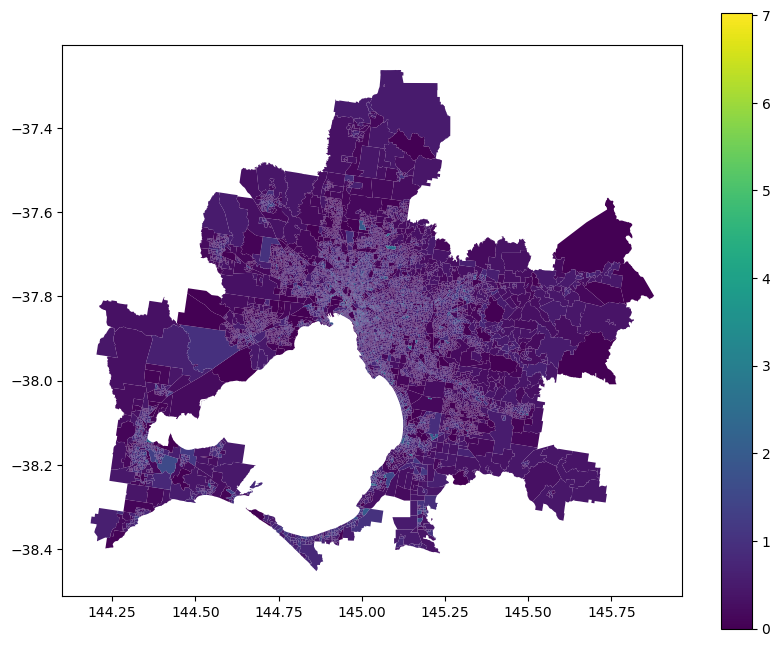

In [98]:
unique_sa1_values  = synthetic_merged[["SA1", "geometry"]].drop_duplicates(subset="SA1")
mysa1_merge = unique_sa1_values.merge(df, on="SA1", how="left")
mysa1_merge.loc[pd.isna(mysa1_merge["sa1_pred"]), "sa1_pred"] = 0
pred_sa1_plot = sa1.merge(mysa1_merge[["SA1", "sa1_pred"]], left_on="SA1_CODE21", right_on="SA1", how='left')
pred_sa1_plot.loc[pd.isna(pred_sa1_plot["sa1_pred"]), "sa1_pred"] = 0

fig, ax = plt.subplots(figsize=(10, 8))
pred_sa1_plot.plot(column="sa1_pred", legend=True, cmap='viridis', ax=ax)
plt.show()

In [128]:
sa1 = gpd.read_file("Shapes\SA1_2021_AUST_SHP_GDA2020\SA1_2021_AUST_GDA2020.shp")
sa2 = gpd.read_file("Shapes\SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp")
sa3 = gpd.read_file("Shapes\SA3_2021_AUST_SHP_GDA2020\SA3_2021_AUST_GDA2020.shp")
poa = gpd.read_file("poa_selected.gpkg")

In [84]:
sa1_sa4 = sa1[["SA1_CODE21", "SA2_CODE21", "SA3_CODE21", "SA4_CODE21"]]
pred_sa1_sa4 = pred_sa1_plot.merge(sa1_sa4, on="SA1_CODE21", how="left")[["POA_CODE21", "SA1_CODE21", "SA2_CODE21", "SA3_CODE21", "SA4_CODE21", "sa1_pred"]]
pred_sa1_sa4

,POA_CODE21,SA1_CODE21,SA2_CODE21,SA3_CODE21,SA4_CODE21,sa1_pred
0,3340,20102100908,201021009,20102,201,0.000000
1,3340,20102100910,201021009,20102,201,0.000000
2,3331,20301103507,203011035,20301,203,0.270625
3,3217,20301103607,203011036,20301,203,0.515504
4,3240,20301103608,203011036,20301,203,0.265812
...,...,...,...,...,...,...
11946,3931,21402159219,214021592,21402,214,0.899134
11947,3931,21402159220,214021592,21402,214,1.320183
11948,3931,21402159221,214021592,21402,214,0.605463
11949,3931,21402159222,214021592,21402,214,0.930433


In [122]:
combined_shape = unary_union(sa1.geometry)

pred_sa2 = pred_sa1_sa4.groupby("SA2_CODE21").sum("sa1_pred").reset_index()
pred_sa2 = sa2.merge(pred_sa2, on="SA2_CODE21", how="right")[["SA2_CODE21", "geometry", "sa1_pred"]]
clipped_pred_sa2 = gpd.overlay(pred_sa2, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

pred_sa3 = pred_sa1_sa4.groupby("SA3_CODE21").sum("sa1_pred").reset_index()
pred_sa3 = sa3.merge(pred_sa3, on="SA3_CODE21", how="right")[["SA3_CODE21", "geometry", "sa1_pred"]]
clipped_pred_sa3 = gpd.overlay(pred_sa3, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

C:\Users\danla\AppData\Local\Temp\ipykernel_26736\4284548406.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7844
Right CRS: None

  clipped_pred_sa2 = gpd.overlay(pred_sa2, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
C:\Users\danla\AppData\Local\Temp\ipykernel_26736\4284548406.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 122 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_pred_sa2 = gpd.overlay(pred_sa2, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
C:\Users\danla\AppData\Local\Temp\ipykernel_26736\4284548406.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CR

In [134]:
pred_poa = pred_sa1_sa4.groupby("POA_CODE21").sum("sa1_pred").reset_index()
pred_poa = poa.merge(pred_poa, on="POA_CODE21", how="right")[["POA_CODE21", "geometry", "sa1_pred"]]
clipped_pred_poa = gpd.overlay(pred_poa, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

C:\Users\danla\AppData\Local\Temp\ipykernel_26736\1285204678.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["GDA2020",DATUM["GDA2020",SPHEROID["GRS_198 ...
Right CRS: None

  clipped_pred_poa = gpd.overlay(pred_poa, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
C:\Users\danla\AppData\Local\Temp\ipykernel_26736\1285204678.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 935 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_pred_poa = gpd.overlay(pred_poa, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")


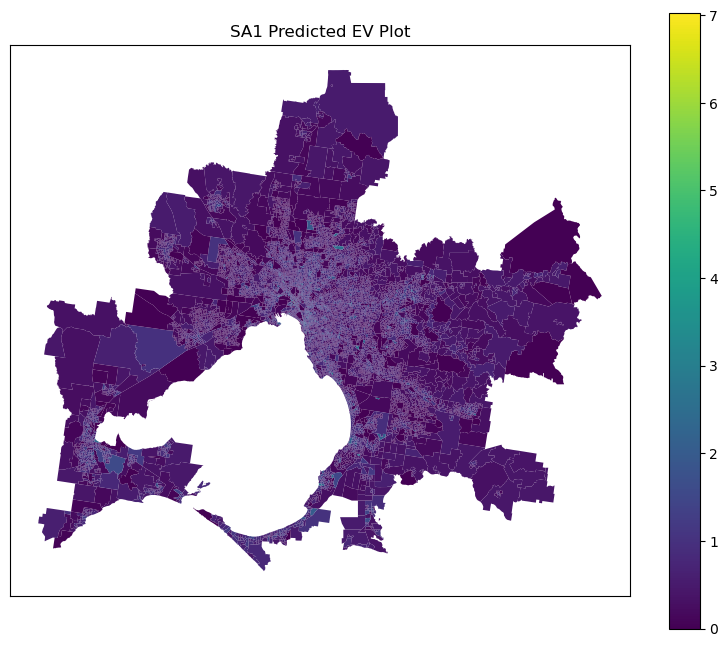

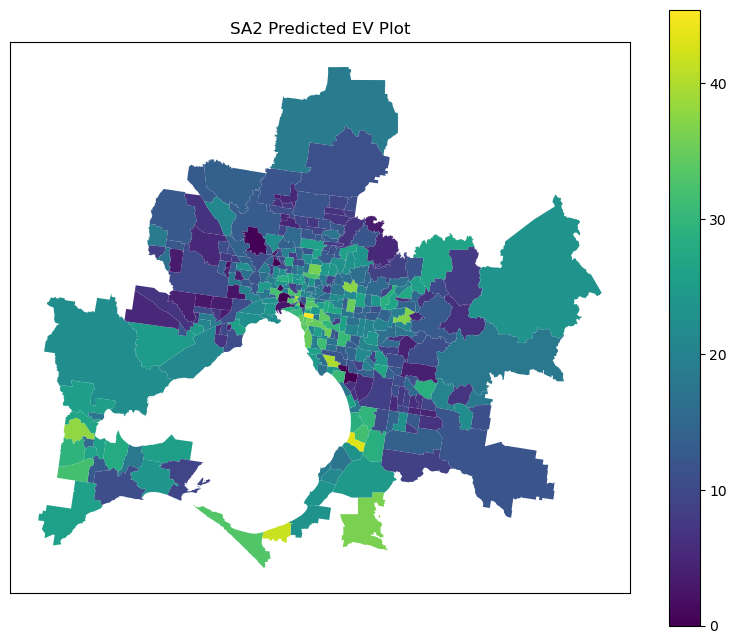

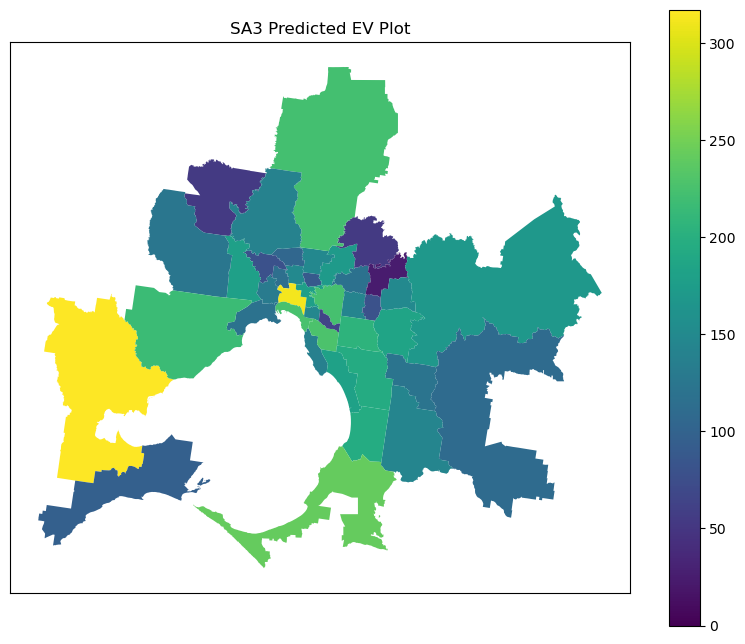

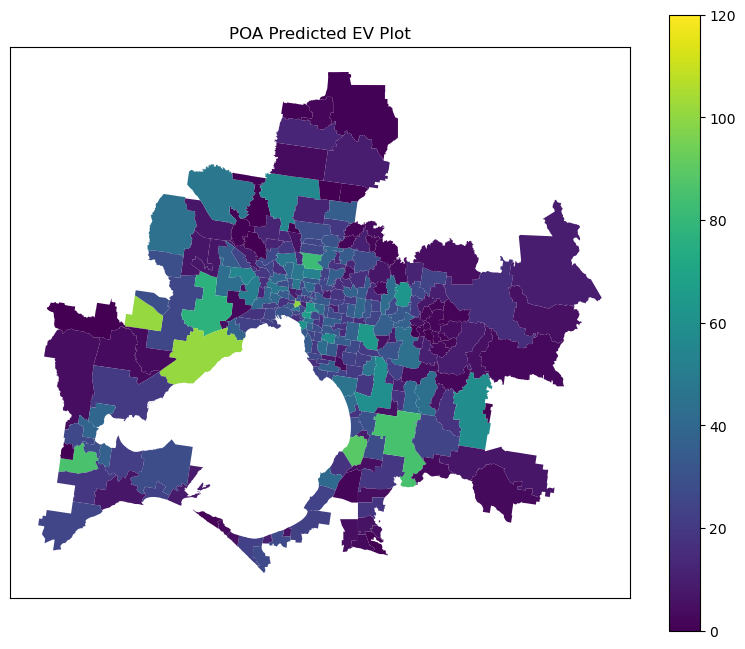

In [141]:
plot_size = (10, 8)

# Create a plot for the SA1
fig, ax = plt.subplots(figsize=plot_size)
pred_sa1_plot.plot(column="sa1_pred", legend=True, cmap='viridis', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("SA1 Predicted EV Plot")
plt.show()

# Create a plot for the SA2
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_sa2.plot(column="sa1_pred", legend=True, cmap='viridis', ax=ax) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("SA2 Predicted EV Plot") 
plt.show()

# Create a plot for the SA3
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_sa3.plot(column="sa1_pred", legend=True, cmap='viridis', ax=ax)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("SA3 Predicted EV Plot")
plt.show()

# Create a plot for the POA
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_poa.plot(column="sa1_pred", legend=True, cmap='viridis', ax=ax, vmax=120)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("POA Predicted EV Plot")
plt.show()